<a href="https://colab.research.google.com/github/pietroventurini/predict-future-sales/blob/main/Predict_Future_Sales_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle competition: Predict Future Sales

In the [**predict future sales**](https://www.kaggle.com/c/competitive-data-science-predict-future-sales) competition we are working with a time-series dataset consisting of daily sales data from Jan 2013 to Oct 2015. The goal is to predict total sales for every product and store in the next month (November 2015).

We are going to approach the problem in this way:
1. **Exploratory data analysis:** take a look at the dataset and perform data cleaning.
2. **Feature engineering:** understand which useful information can be extracted from the features.
3. **Modelling:** choose a suitable model for the problem.
4. **Training:** train the model on the training set
5. **Model evaluation:** try to predict future sales and evaluate the performances of the model.

# Exploratory Data Analysis



Let's start by exploring the content of our dataset. According to the competition description, the training data is provided in 4 different .csv files:

- `sales_train.csv` - the training set. Daily historical data from January 2013 to October 2015.
- `items.csv` - supplemental information about the items/products.
- `item_categories.csv`  - supplemental information about the items categories.
- `shops.csv`- supplemental information about the shops.

Sales and shops are represented by the following fields:

- `ID` - an Id that represents a (Shop, Item) tuple within the test set
- `shop_id` - unique identifier of a shop
- `item_id` - unique identifier of a product
- `item_category_id` - unique identifier of item category
- `item_cnt_day` - number of products sold. You are predicting a monthly amount of this measure
- `item_price` - current price of an item
- `date` - date in format dd/mm/yyyy
- `date_block_num` - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- `item_name` - name of item
- `shop_name` - name of shop
- `item_category_name` - name of item category

The content of the datasets is in russian, so we may think of translating it into english because many interesting features can be extracted from the names of the products, shops and categories, for instance:
- Books - Audio Books
- Books - Computer books
- Books - …

From those names we could build a feature that contains only the top level category. The translation can be done manually using some python libraries (e.g. googletrans), but other competitors have already taken the trouble to translate it for us. Translated datasets can be recognized by the `_en` suffix. However, translation can break the structure of some names (e.g. russian shop names comes in the format `city | type | name`, so, by translating them in english we risk to break that structure) and complicate our life when extracting features from them.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import time
import gc

from sklearn.cluster import dbscan
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from google.colab import drive


# Constants
RND_SEED = 11
use_drive = True

### Loading data

In [ ]:
if use_drive:
  drive_name = '/content/drive'
  drive.mount(drive_name)
  drive_folder = 'Colab Notebooks/Predict Future Sales' # Files location in Google Drive
  drive_location = drive_name + '/My Drive/' + drive_folder + '/'
else:
  drive_location = './'

TRAIN_PATH = drive_location + 'datasets/sales_train.csv'
CATEGORIES_PATH = drive_location + 'datasets/item_categories.csv'
ITEMS_PATH= drive_location + 'datasets/items.csv'
SHOPS_PATH = drive_location + 'datasets/shops.csv'
TEST_PATH = drive_location + 'datasets/test.csv'
SUBMISSION_PATH = drive_location + 'datasets/sample_submission.csv'

train = pd.read_csv(TRAIN_PATH)
items = pd.read_csv(ITEMS_PATH)
categories = pd.read_csv(CATEGORIES_PATH)
shops = pd.read_csv(SHOPS_PATH)
test = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SUBMISSION_PATH, index_col='ID')

train.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
print("\n-----------Information-----------")
print(train.info())
print("\n----------Null values-----------")
print(train.isnull().sum())
print("\n----------Shape of Data----------")
print(train.shape)


-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None

----------Null values-----------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

----------Shape of Data----------
(2935849, 6)


### Downcasting

As we can see from the information block, the training set is 134.4+ MB in size, so, in order to reduce the memory occupation, we can downcast the dataframe from _int64_ and _float64_ to _int16_ and _float32_.

In [ ]:
def downcast(df):
  """Downcasts float64 types to float32 and int64/int/32 to int16."""
  float_cols = [c for c in df if df[c].dtype == 'float64']
  int_cols = [c for c in df if df[c].dtype in ['int64', 'int32']]
  df[float_cols] = df[float_cols].astype(np.float32)
  df[int_cols] = df[int_cols].astype(np.int16)
  return df

train = downcast(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int16  
 2   shop_id         int16  
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB


We have reduced the size of the training set from 134.4 MB down to 61.6+ MB.

## Data cleaning

In [ ]:
# remove duplicated rows
train = train.drop_duplicates()

# view information about prices and sold quantities
train[['item_price', 'item_cnt_day']].describe()

,item_price,item_cnt_day
count,2.935843e+06,2.935843e+06
mean,8.906237e+02,1.242641e+00
std,1.726442e+03,2.612216e+00
min,-1.000000e+00,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,3.079800e+05,2.169000e+03


The first thing that catches the eye is the fact that the minimum price and the minimum sold quantity are negative, respectively, the minimum price is -1 and the minimum sold quantity is -22. 

### Negative prices

In [ ]:
# items with price <= 0
neg_items = train[train.item_price <= 0]
neg_items

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [ ]:
# get details of the item with price < 0
neg_item = neg_items.iloc[0]
items.loc[items['item_id'] == neg_item['item_id']]

,item_name,item_id,item_category_id
2973,"DmC Devil May Cry [PS3, русские субтитры]",2973,19


Fortunately, there is only one item with a negative price. We could replace it with the median of the prices, but let's try to be more precise. The item in question is a PS3 game. Typically, game prices decreases over time since their release date, and tend to be the same among different sellers. Therefore, let's see if other shops sold the same item in that date (extending the search to the same week or month, if necessary), and use that price as a proxy for our missing value. Otherwise, we could average the price for that item from the same shop in the next few days.

In [ ]:
train[(train['item_id'] == neg_item['item_id']) & (train['date'] == neg_item['date'])]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,15.05.2013,4,25,2973,1249.5,1.0
469026,15.05.2013,4,46,2973,1249.5,1.0
469951,15.05.2013,4,45,2973,1249.0,1.0
484683,15.05.2013,4,32,2973,-1.0,1.0


In [ ]:
# set the product price to that value
train.loc[train.item_price <= 0, 'item_price'] = 1249.0

### Negative quantities sold

Let's now deal with negative quantities sold. By looking at some of the discussions on the competition page, I've seen that many people considered negative values for `item_cnt_day` as returned items. Let's stick to that interpretation and set them equal to zero.

In [ ]:
train.loc[train.item_cnt_day < 0, 'item_cnt_day'] = 0

### Outliers

Let's take a look at the distributions of prices and quantities.

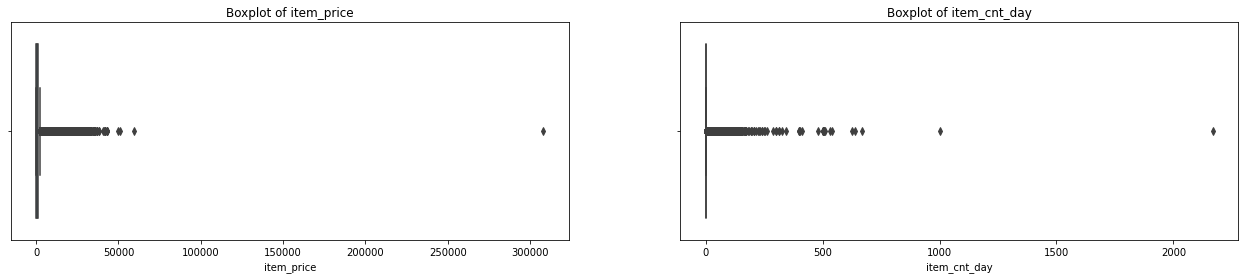

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(22,4))
sns.boxplot(x='item_price', data=train, ax=axs[0])
sns.boxplot(x='item_cnt_day', data=train, ax=axs[1])
axs[0].set_title('Boxplot of item_price')
axs[1].set_title('Boxplot of item_cnt_day')
plt.show()

First of all, there is an item with a very large price that we should inspect. Similarly there are few items with a large number of units sold in a single day.

In [ ]:
# most expensive item
train.loc[train.item_price.idxmax()]

date              13.12.2013
date_block_num            11
shop_id                   12
item_id                 6066
item_price            307980
item_cnt_day               1
Name: 1163158, dtype: object

In [ ]:
# most sold item in a day
train.loc[train.item_cnt_day.idxmax()]

date              28.10.2015
date_block_num            33
shop_id                   12
item_id                11373
item_price          0.908714
item_cnt_day            2169
Name: 2909818, dtype: object

In [ ]:
fig = px.scatter(train.loc[train.item_id == 11373], x='date', y='item_cnt_day', title="Quantities of item #11373 (Boxberry delivery) sold every day")
fig.show()

I decided to remove those outliers since
1. The item with cost 6066 (which is a product called _"Radmin 3"_) has been sold exactly one time on that day only.
2. The item sold 2169 times in a single day (that i suspect to be a service rather than a product, because of its name _"Delivery to the delivery point (Boxberry)"_) is sold in much smaller quantities in every other date.

### Duplicated shops

As other participants pointed out, some shops have the same name. The shops list is short enough to be inspected manually so we can find them. If it were longer, we could have applied some fuzzy string matching algorithm on the shops names (e.g. we could have measured similarity between names using the Levenshtein distance) in order to detect similar names. Since there was no further information about the shops other than their name, and since in the test set they appear with only one of the two IDs, I decided to merge together those with the same name, using the IDs in the test set.
- 0 ⇒ 57
- 1 ⇒ 58
- 11 ⇒ 10
- 40 ⇒ 39

In [ ]:
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1500]

In [ ]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 11, 'shop_id'] = 10
train.loc[train.shop_id == 40, 'shop_id'] = 39

# keep only shops that are present either in the train set or in the test set
shops = shops.loc[shops.shop_id.isin(train.shop_id) | shops.shop_id.isin(test.shop_id)]

In [ ]:
print('Shops only in the train set:', set(shops.shop_id) - set(test.shop_id))
print('Shops only in the test set:', set(shops.shop_id) - set(train.shop_id))

Shops only in the train set: {32, 33, 8, 9, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30}
Shops only in the test set: set()


# Feature engineering

In this section we will try to create features that may help the model to make more accurate predictions about future sales. Remember that we are requested to predict sales for product-store pairs.

## Shops

Let's start by dealing with shops. Each shops is simply described by `shop_name`. By looking at their names, it looks like that every name has the structure `Shop City | Shop Type | Shop Name` (this was pointed out by other competitors who understand russian language). Thanks to this, we can extract those information into separate features.

In [ ]:
shops.head()

,shop_name,shop_id
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6


In [ ]:
# remove non alphanumeric characters and numbers
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()

# get city names (first word) 
shops['shop_city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

# get shop types
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x 
                         else 'трц' if 'трц' in x 
                         else 'трк' if 'трк' in x 
                         else 'тц' if 'тц' in x 
                         else 'тк' if 'тк' in x 
                         else np.nan)

# manually set type for online shops (determined on type of items sold)
shops.loc[shops['shop_id'].isin([12, 55]), ['shop_city','shop_type']] = 'online'

In [ ]:
# add first month to each shop
shops = shops.join(train.groupby('shop_id')['date_block_num'].min()).rename(columns={'date_block_num':'shop_first_month'})

# add last month to each shop
shops = shops.join(train.groupby('shop_id')['date_block_num'].max()).rename(columns={'date_block_num':'shop_last_month'})
shops.head()

,shop_name,shop_id,shop_city,shop_type,shop_first_month,shop_last_month
2,адыгея тц мега,2,адыгея,тц,0,33
3,балашиха трк октябрькиномир,3,балашиха,трк,0,33
4,волжский тц волга молл,4,волжский,тц,0,33
5,вологда трц мармелад,5,вологда,трц,1,33
6,воронеж плехановская,6,воронеж,NaN,0,33


In [ ]:
# label encoding names
shops = shops.fillna('NO_DATA')
cols_to_encode = ['shop_name','shop_city','shop_type']
shops[cols_to_encode] = shops[cols_to_encode].apply(LabelEncoder().fit_transform)
#shops = shops.join(pd.get_dummies(shops[cols_to_encode]).add_suffix('_enc'))

shops = downcast(shops)
shops.head(5)

,shop_name,shop_id,shop_city,shop_type,shop_first_month,shop_last_month
2,0,2,1,6,0,33
3,1,3,2,4,0,33
4,2,4,3,6,0,33
5,3,5,4,5,1,33
6,4,6,5,0,0,33


For every shop in the test set we have data up to the last month in the training set (`date_block_num = 33`). There are some shops that do not pop up in the test set, anyway, they can still be useful to predict certain product sales for other shops.

In [ ]:
print("Shops that are not in the test set: ", shops.loc[~shops.shop_id.isin(test.shop_id), 'shop_id'].to_list())
# uncomment next line to see details about those shops
# shops[~shops.shop_id.isin(test.shop_id)]

Shops that are not in the test set:  [8, 9, 13, 17, 20, 23, 27, 29, 30, 32, 33, 43, 51, 54]


## Item categories


Categories are described by a name which can have either the form `type - subtype` (e.g. `Книги - Путеводители` which means `books - travel guides`) or a single name (e.g. `Доставка товара` which means `delivery of goods`). Let's split composite category names into:
- section
- main category name
- main sub-category name
- secondary sub-category name

For instance, the string `Аксессуары - PS4` gets transformed into:

|   Section   | name | sub_name | sec_sub_name |
|:-----------:|:----:|:--------:|:------------:|
| accessories |  PS4 |    PS    |       4      |

Here we have to get our hands dirty and deal with each category in detail because not every name has that structure.

Note: I decided to translate sections into english for visualization purposes, but note that it was not necessary since later we will perform label encodings.

In [ ]:
# before
categories[:10]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [ ]:
categories['split'] = categories['item_category_name'].str.split('-')
categories['section'] = categories['split'].map(lambda x: x[0].strip())
categories['name'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0])
categories = categories[['item_category_id', 'section', 'name']]

# games
categories.loc[26:31, 'sub_name'] = categories.loc[26:31, 'name']
categories.loc[26:31, 'name'] = categories.loc[26:31, 'section'].str.split(' ').map(lambda x: x[1])
categories.loc[18:31, 'section'] = 'games'

# PlayStation stuff
is_ps = categories.name.str.contains('PS')
categories.loc[is_ps, 'sec_sub_name'] = categories.loc[is_ps, 'name'].map(lambda x: x.split('PS')[1])
categories.loc[is_ps, 'sub_name'] = 'PS'

# XBOX stuff
is_xbox = categories.name.str.contains('XBOX')
categories.loc[is_xbox, 'sec_sub_name'] = categories.loc[is_xbox, 'name'].map(lambda x: x.split('XBOX')[1])
categories.loc[is_xbox, 'sub_name'] = 'XBOX'

# split name - subname
categories.loc[45, 'sec_sub_name'] = '1C'
categories.loc[43:45, 'sub_name'] = 'audiobooks'
categories.loc[55, 'sec_sub_name'] = 'локального'
categories.loc[56, 'sec_sub_name'] = 'фирменного'
categories.loc[55:56, 'sub_name'] = 'CD'
categories.loc[81:82, 'sub_name'] = categories.name.loc[81:82].map(lambda x: x[x.find('(')+1:x.find(')')])

# extract subname within brackets e.g. {name: "Live! (Цифра)"} --> {sub_name: "Live!", sec_sub_name: "Цифра"}
has_subname = categories.name.str.contains('\(.*?\)')
categories.loc[has_subname, 'sec_sub_name'] = categories.loc[has_subname, 'name'].map(lambda x: x[x.find('(')+1:x.find(')')])
categories.loc[has_subname, 'sub_name'] = categories.loc[has_subname, 'name'].str.split('(').map(lambda x: x[0])

# rename sections
categories.loc[1:7, 'section'] = 'accessories'
categories.loc[8, 'section'] = 'tickets'
categories.loc[9, 'section'] = 'delivery of goods'
categories.loc[10:17, 'section'] = 'consoles'
categories.loc[32:36, 'section'] = 'cards'
categories.loc[37:41, 'section'] = 'movies'
categories.loc[42:54, 'section'] = 'books'
categories.loc[55:60, 'section'] = 'music'
categories.loc[61:72, 'section'] = 'gifts'
categories.loc[73:78, 'section'] = 'software'
categories.loc[81:82, 'section'] = 'disks'
categories.loc[83, 'section'] = 'batteries'

In [ ]:
# after
categories[:10]

,item_category_id,section,name,sub_name,sec_sub_name
0,0,PC,Гарнитуры/Наушники,NaN,NaN
1,1,accessories,PS2,PS,2
2,2,accessories,PS3,PS,3
3,3,accessories,PS4,PS,4
4,4,accessories,PSP,PS,P
5,5,accessories,PSVita,PS,Vita
6,6,accessories,XBOX 360,XBOX,360
7,7,accessories,XBOX ONE,XBOX,ONE
8,8,tickets,Билеты (Цифра),Билеты,Цифра
9,9,delivery of goods,Доставка товара,NaN,NaN


In [ ]:
# label encoding names
categories = categories.fillna('NO_DATA')
cols_to_encode = ['section','name','sub_name','sec_sub_name']
categories[cols_to_encode] = categories[cols_to_encode].apply(LabelEncoder().fit_transform)
#categories = categories.join(pd.get_dummies(categories[['section','name','sub_name','sec_sub_name']]).add_suffix('_enc'))

#categories = categories.drop(columns=cols_to_encode)
categories = downcast(categories)
categories.rename(columns={'name':'cat_name', 'sub_name':'cat_sub_name', 'sec_sub_name':'cat_sec_sub_name'}, inplace=True)
categories

# note: to later perform inverse_transform see https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

,item_category_id,section,cat_name,cat_sub_name,cat_sec_sub_name
0,0,0,32,3,7
1,1,1,12,4,3
2,2,1,13,4,4
3,3,1,14,4,5
4,4,1,16,4,8
...,...,...,...,...,...
79,79,14,55,3,7
80,80,14,28,3,7
81,81,7,62,19,16
82,82,7,63,19,17


## Items

If we manually inspect item names, we'll soon discover that they share some kind of structure which, in general, is 

```item_name [category_feature] (additional_info)```

where the terms within brackets are optional.

In [ ]:
items.tail(10)

,item_name,item_id,item_category_id
22160,ЯРМАРКА ТЩЕСЛАВИЯ (Регион),22160,40
22161,ЯРОСЛАВ. ТЫСЯЧУ ЛЕТ НАЗАД э (BD),22161,37
22162,ЯРОСТЬ,22162,40
22163,ЯРОСТЬ ( регион),22163,40
22164,ЯРОСТЬ (BD),22164,37
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62
22169,Яйцо дракона (Игра престолов),22169,69


In [ ]:
import re
def extract_from_square_brackets(s):
  s = re.search(r"\[(.*?)\]", s)
  if s:
    return s.group(1)

def extract_from_round_brackets(s):
  s = re.search(r"\((.*?)\)", s)
  if s:
    return s.group(1)

def name_correction(x):
  if x:
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
  return x

items['item_name_2'] = items['item_name'].apply(extract_from_square_brackets)
items['item_name_3'] = items['item_name'].apply(extract_from_round_brackets)

items['item_name'] = items['item_name'].apply(name_correction)
items['item_name_2'] = items['item_name_2'].apply(name_correction)
items['item_name_3'] = items['item_name_3'].apply(name_correction)

items.fillna('0', inplace=True)

Let's take a look at what we have done.

In [ ]:
items[items['item_name'].str.startswith('need for speed')]

,item_name,item_id,item_category_id,item_name_2,item_name_3
5012,need for speed жажда скорости,5012,40,0,0
5013,need for speed жажда скорости,5013,38,0,3d bd
5014,need for speed жажда скорости,5014,37,0,bd
5217,need for speed prostreet,5217,31,pc цифровая версия,0
5218,need for speed shift,5218,31,pc цифровая версия,0
...,...,...,...,...,...
5275,need for speed most wanted,5275,22,ps vita русская версия,a criterion game
5276,need for speed most wanted,5276,19,ps3 русская версия,a criterion game
5277,need for speed most wanted,5277,23,xbox 360 русская версия,a criterion game
5278,need for speed most wanted 5 1 0,5278,21,psp английская версия,essentials


At this point, I noticed that some patterns repeated themselves inside `item_name` of different instances. For istance, the previous dataframe shows the items that contain the string `need for speed` (a popular car racing game) in their `item_name`. We can reasonably assume that, different titles of the same game franchise behave similarly in terms of copies sold. 

As we will see later (spoiler alert), for a fraction of the items for which we are asked to predict future sales, we don't have any past information, since they have been released on November 2015. For this reason I think that, if we provide explicitly the group that links different item names together, then it would help our model at predicting sales for new items.

The same applies for `item_name_2`, but it is less critical: consider, for instance, the names `ps vita русская версия`, `ps3 русская версия`, `xbox 360 русская версия`. Those were the strings within square brackets in the original `item_name`. We already know the platform (xbox, ps3...) since we extracted that information from the category name, therefore, we should focus on isolating the other portion of the string (`русская версия`, which means _Russian version_).

I didn't know any sophisticated technique for extracting common patterns from strings. The first thing I tried was to use some clustering algorithms using some particular metrics to measure string similarity. I tried using DBSCAN (which do not require to choose a-priori the number of clusters) as a clustering algorithm and the [Jaccard distance](https://en.wikipedia.org/wiki/Jaccard_index) as a dissimilarity metric, which is defined as:

$$J_\delta(X_1, X_2) = 1 - J(X_1, X_2) = 1 - \frac{|X_1 \cap X_2|}{|X_1 \cup X_2|}$$

Consider two strings _"need for speed prostreet"_ and _"need for speed most wanted"_, the Jaccard index measures how many words appear in both strings, divided by the total number of different words in them:

$$\frac{|\{\mathrm{need}, \mathrm{for}, \mathrm{speed}\}|}{|\{\mathrm{need}, \mathrm{for}, \mathrm{speed}, \mathrm{prostreet}, \mathrm{most}, \mathrm{wanted}\}|} = \frac{3}{6}=0.5$$

The Jaccard distance, in this case, is $1-0.5=0.5$.

I tried using the sklearn implementation of DBSCAN with a custom metric.

```python
import numpy as np
from sklearn.cluster import dbscan

item_names = items['item_name']

def jaccard_dist(x, y):
    i, j = int(x[0]), int(y[0])
    str1, str2 = item_names[i], item_names[j]
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return  1 - float(len(c)) / (len(a) + len(b) - len(c))

X = np.arange(len(item_names)).reshape(-1, 1)
dbs = dbscan(X, metric=jaccard_dist, eps=0.6, min_samples=2, algorithm='brute')
```

Unfortunately, the algorithm took too long and could not complete the computation. This is because the number of points (items) is quite large (22170), and the algorithm have to compare each item with every other items **multiple times**, each time **recomputing the distance**.

Another approach I tried was to compute the distance matrix a-priori, and then passing it to the DBSCAN algorithm.

**Note:** the Jaccard distance is not the most appropriate metric to use for this kind of task, for instance, if we had two strings _"Batman Begins"_
and _"Batman the dark knight rises"_, we would like to consider them similar to each other, anyway, by using the Jaccard distance, they would be considered quite different: $1-\frac{1}{6} = 0.833$. For this reason, I decided to apply the procedure described above on a subset of the string (considering only the first three words, i.e. the first word-level trigram).

In [ ]:
def jaccard(x, y):
  """Return jaccard distance between two sets of string elements
  e.g. x = {'the', 'first', 'string'}, y = {'another', 'string'}."""
  return 1 - len(x.intersection(y)) / len(x.union(y))

t_start = time.time()

# consider only first 3 words of item_name
item_names = [set(x.split()[:3]) for x in items['item_name']]
d = np.zeros((len(item_names), len(item_names)))
for i in range(len(item_names)):
  for j in range(i, len(item_names)):
    d[j,i] = d[i,j] = jaccard(item_names[i], item_names[j])

print(f"Time to compute distance matrix: {time.time() - t_start} s")

t_start = time.time()
# min_samples = 1 --> we allow clusters with only one item (problem: exceed memory limit)
dbs = dbscan(d, metric='precomputed', eps=0.6, min_samples=1)
print(f"Time to run DBSCAN: {time.time() - t_start} s")

# label encode items
items['item_name'] = dbs[1]


# label encodings
items[['item_name_2', 'item_name_3']] = items[['item_name_2', 'item_name_3']].apply(LabelEncoder().fit_transform)
items = downcast(items)

del d, item_names, dbs
gc.collect()

Time to run DBSCAN: 10.919206619262695 s


In [ ]:
items.head()

,item_name,item_id,item_category_id,item_name_2,item_name_3
0,0,0,40,1,915
1,1,1,76,43,0
2,2,2,40,1,666
3,3,3,40,1,665
4,4,4,40,1,1036


## Item sales

As we've seen so far, there are periods in which no data is available for a certain shop or for a certain item (maybe because it is not available in a certain store), so, what should we do for those cases? Extending the dataset by inlcuding every possible combination of day-shop-item would make the training set reaching over 1B entries.

In [ ]:
print("Power set (date ⨯ shop ⨯ item) size is", len(train.date.unique()) * len(train.shop_id.unique()) * len(train.item_id.unique()))

Power set (date ⨯ shop ⨯ item) size is 1262654624


If we considered only `date_block_num` instead of `date`, we would end up with ~41M entries, but we would lose information about daily sales, which, intuitively, can turn useful when predicting sales for November 2015.

In [ ]:
print("Power set (date_block_num ⨯ shop ⨯ item) size is", len(train.date_block_num.unique()) * len(train.shop_id.unique()) * len(train.item_id.unique()))

Power set (date_block_num ⨯ shop ⨯ item) size is 41518624


Let's start by dealing with sales by crafting new features for items such as the first day in which each item was sold (we will call this variable `first_sale_block` since we are interested in monthly sales).

In [ ]:
items['first_sale_block'] = train.groupby('item_id')['date_block_num'].min()
items['first_sale_block'].fillna(34, inplace=True)
items['first_sale_block'] = items['first_sale_block'].astype('int8')

### Grid of shops-items

In the next script we will consider only the shops that are present both in the training and in the test set. Then, we construct a grid of triplets (`date_block_num`, `shop_id`, `item_id`) grouping together, for each month, all the shops and all the items for which we have a record in the training set.

In [ ]:
# keep in train only sales associated to shops that are also in the test set
train = train.merge(test[['shop_id']].drop_duplicates(), how='inner')

from itertools import product

# create grid of (date_block_num, shop_id, item_id) triplets from train set
grid = []

for block_num in train['date_block_num'].unique():
  mthly_shops = train[train.date_block_num == block_num]['shop_id'].unique()
  mthly_items = train[train.date_block_num == block_num]['item_id'].unique()
  grid.append(np.array(list(product(*[mthly_shops, mthly_items, [block_num]])), dtype='int32'))

sales = pd.DataFrame(np.vstack(grid), columns=['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)

# get monthly sales for each (shop, item) pair in train set
mthly_sales = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'})
sales = pd.merge(sales, mthly_sales, how='left', on=['shop_id', 'item_id', 'date_block_num']).fillna(0)
sales['item_cnt_month'] = sales['item_cnt_month'].astype(int)

# get monthly average price for each (shop, item) pair in train set
avg_prices = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].mean().reset_index().rename(columns={'item_price': 'item_avg_price'})
sales = pd.merge(sales, avg_prices, how='left', on=['shop_id', 'item_id', 'date_block_num']).fillna(0.)

sales = downcast(sales)
sales = sales.sort_values(['date_block_num', 'shop_id', 'item_id'])

In [ ]:
# merge train with items
sales = sales.merge(items, on=['item_id'], how='left')

# merge test with items
test = test.merge(items, on=['item_id'], how='left')

# merge train with categories
sales = sales.merge(categories, on=['item_category_id'], how='left')

# merge test with categories
test = test.merge(categories, on=['item_category_id'], how='left')

# merge train with shops
sales = sales.merge(shops, on=['shop_id'], how='left')

# merge test with shops
test = test.merge(shops, on=['shop_id'], how='left')

del grid, mthly_sales, mthly_shops, mthly_items, categories, shops, items
gc.collect()

50

## Dates

Possible dates features may be: 
- Weekends and holidays sales
- Number of days in the month
- Month number (for seasonal items)

Note that, in our training set, for every date between `2013-01-01` and `2015-10-31`, there exist at least one sale. Recall that the variable `date_block_num` varies over the range 0-33, where 0 corresponds to January 2013 and 33 to October 2015, and we are requested to predict sales for November 2015.

In [ ]:
# create dates from sdate (Jan 1, 2013) to edate (Nov 30, 2015)
sdate = pd.to_datetime('2013-01-01')
edate = pd.to_datetime('2015-11-30')
dates = pd.date_range(sdate, edate, freq='d').to_frame(index=False, name='date')

# add features
dates['year'] = dates['date'].dt.year
dates['month'] = dates['date'].dt.month.astype('int8')
dates['date_block_num'] = (dates['year']-2013) * 12 + dates['month'] - 1
dates['weekday'] = dates['date'].dt.weekday
dates['is_weekend'] = dates['date'].dt.day_name().map(lambda x: x in ['Saturday', 'Sunday'])

# dummies: 0: Monday ... 6: Sunday
dates = pd.get_dummies(dates, columns=['weekday']) 
weekdays = ['weekday_{}'.format(i) for i in range(7)]

# count days in each month
monthly_data = dates.groupby(['year','month','date_block_num'])[weekdays].agg('sum').reset_index()
monthly_data['month_length'] = monthly_data[weekdays].sum(axis=1).astype('int8')

# count number of weekend (saturdays and sundays) in each month
monthly_data['weekend_days'] = dates.groupby(['date_block_num'])[['is_weekend']].agg('sum').astype('int8')

# encode year (0: 2013, 1: 2014, 2: 2015)
monthly_data['year'] = monthly_data['year'] - 2013

# merge sales and test with monthly data
sales = sales.merge(monthly_data[['year','month','date_block_num','month_length','weekend_days']], on='date_block_num', how='left')
sales = downcast(sales)

test['date_block_num'] = 34
test = test.merge(monthly_data[['year','month','date_block_num','month_length','weekend_days']], on='date_block_num', how='left')
test = downcast(test)

In [ ]:
del train, dates, monthly_data, weekdays, sdate, edate
gc.collect()

50

In [ ]:
sales.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,item_avg_price,item_name,item_category_id,item_name_2,item_name_3,first_sale_block,section,cat_name,cat_sub_name,cat_sec_sub_name,shop_name,shop_city,shop_type,shop_first_month,shop_last_month,year,month,month_length,weekend_days
0,2,19,0,0,0.0,18,40,1,0,0,10,5,3,7,0,1,6,0,33,0,1,31,8
1,2,27,0,1,2499.0,26,19,54,0,0,8,13,4,4,0,1,6,0,33,0,1,31,8
2,2,28,0,0,0.0,26,30,70,0,0,8,11,16,7,0,1,6,0,33,0,1,31,8
3,2,29,0,0,0.0,26,23,84,0,0,8,19,6,0,0,1,6,0,33,0,1,31,8
4,2,32,0,0,0.0,28,40,1,0,0,10,5,3,7,0,1,6,0,33,0,1,31,8


## Mean encodings

We will now compute mean encodings for categorical columns. If we want, we can use different approaches in order to cope with overfitting, such as:
- K-Fold
- Leave-One-Out
- Smoothing
- Expanding mean

We can compute mean encodings with all the methods above, and, for each method, we select the encoding with the largest value of the Pearson correlation coefficient with respect to the true target values.

In [ ]:
def mean_encoding(sales, groupby=['date_block_num', 'item_id'], feature_enc_name=None, clip=False):
  """Compute mean eancodings grouping with respect to `groupby` parameter.
  No regularization is applied."""
  if groupby == []:
    groupby = ['date_block_num', 'item_id']
  means = sales.groupby(groupby)['item_cnt_month'].mean().reset_index().rename(columns={'item_cnt_month': feature_enc_name})
  if clip:
    means[feature_enc_name].clip(0, 20, inplace=True)
  sales = sales.merge(means, on=groupby, how='left')
  sales.fillna(sales['item_cnt_month'].mean(), inplace=True)
  return sales

MEAN_REGULARIZATION = False

if MEAN_REGULARIZATION:
  target = 'item_cnt_month'
  global_mean = sales[target].mean()
  y_sales = sales[target].values
  #mean_encoded_cols = ['shop_id', 'item_id', 'item_category_id', 'section', 'name', 'shop_city', 'shop_type']
  mean_encoded_cols = ['shop_id', 'item_id', 'item_category_id']

  for col in mean_encoded_cols:
      col_tr = sales[[col] + [target]].copy()
      corrcoef = pd.DataFrame(columns=['Cor']) # will contain correlation coefficients of each encoding scheme for the current column

      # Mean encodings - KFold
      col_tr[col+'_mean_Kfold'] = global_mean
      kf = KFold(n_splits=5, shuffle=False)
        
      # for tr_idx, val_idx in kf.split(col_tr):
      #     X_tr, X_val = col_tr.iloc[tr_idx].copy(), col_tr.iloc[val_idx].copy()
      #     X_val[col+'_mean_Kfold'] = X_val[col].map(X_tr.groupby(col)[target].mean())
      #     col_tr.iloc[val_idx] = X_val
      
      # one-liner to avoid copy()
      for tr_idx, val_idx in kf.split(col_tr):
          col_tr.loc[val_idx, col+'_mean_Kfold'] = col_tr.loc[val_idx, col].map(col_tr.iloc[tr_idx].groupby(col)[target].mean())
      
      col_tr[col+'_mean_Kfold'].fillna(global_mean, inplace=True)
      corrcoef.loc[col+'_mean_Kfold'] = np.corrcoef(y_sales, col_tr[col+'_mean_Kfold'])[0][1] # np.corrcoef returns a 2⨉2 matrix 
      
      # Mean encodings - Leave One Out
      col_tr[col+'_cnt_month_sum'] = col_tr[col].map(col_tr.groupby(col)[target].sum())
      col_tr[col+'_cnt_month_count'] = col_tr[col].map(col_tr.groupby(col)[target].count())
      col_tr[col+'_mean_LOO'] = (col_tr[col+'_cnt_month_sum'] - col_tr[target]) / (col_tr[col+'_cnt_month_count'] - 1)
      col_tr[col+'_mean_LOO'].fillna(global_mean, inplace=True)
      corrcoef.loc[col+'_mean_LOO'] = np.corrcoef(y_sales, col_tr[col+'_mean_LOO'])[0][1]

      # Mean encodings - Smoothing
      alpha = 100
      col_tr[col+'_mean'] = col_tr[col].map(col_tr.groupby(col)[target].mean())
      col_tr[col+'_mean_smooth'] = (col_tr[col+'_mean']*col_tr[col+'_cnt_month_count'] + global_mean*alpha) / (col_tr[col+'_cnt_month_count'] + alpha)
      col_tr[col+'_mean_smooth'].fillna(global_mean, inplace=True)
      corrcoef.loc[col+'_mean_smooth'] = np.corrcoef(y_sales, col_tr[col+'_mean_smooth'])[0][1]

      # Mean encodings - Expanding Mean
      cumsum = col_tr.groupby(col)[target].cumsum() - col_tr[target]
      sumcnt = col_tr.groupby(col).cumcount()
      col_tr[col+'_mean_expanding'] = cumsum / sumcnt
      col_tr[col+'_mean_expanding'].fillna(global_mean, inplace=True)
      corrcoef.loc[col+'_mean_expanding'] = np.corrcoef(y_sales, col_tr[col+'_mean_expanding'])[0][1]

      # append mean encoded column with highest correlation to the training set
      sales = pd.concat([sales, col_tr[corrcoef['Cor'].idxmax()]], axis=1)

      print(corrcoef.sort_values('Cor', ascending=False))
  del col_tr
else:
  sales = mean_encoding(sales, ['date_block_num', 'item_id'], 'item_mean', clip=True)
  sales = mean_encoding(sales, ['date_block_num', 'shop_id', 'item_name'], 'item_name_mean', clip=True)
  sales = mean_encoding(sales, ['date_block_num', 'item_id', 'shop_city'], 'item_city_mean', clip=True)
  sales = mean_encoding(sales, ['date_block_num', 'shop_id', 'item_category_id'], 'shop_category_mean', clip=True)

In [ ]:
# merge all data
test['date_block_num'] = 34
test['item_cnt_month'] = 0
sales = pd.concat([sales, test], axis=0)
sales = sales.drop(columns=['ID'])
sales['date_block_num'] = sales['date_block_num'].astype('int8')
sales = downcast(sales)

# free memory
gc.collect()

0

Next, we 

1. Add a new feature called `new`, which indicates if a certain item has been released on that month.
2. Compute the number of months that are passed since the release of the product (i.e. since `first_sale_block`)

In [ ]:
# it is a new product?
sales['new'] = sales['first_sale_block'] == sales['date_block_num']

# age of product (in months)
sales['first_sale_block'] = sales['date_block_num'] - sales['first_sale_block']
sales.rename(columns={'first_sale_block':'months_since_release'}, inplace=True)

# shop opening block
sfb = sales.groupby('shop_id')['date_block_num'].min()
sfb.name = 'shop_first_block'
sales = sales.merge(sfb, how='left', on='shop_id')
sales['shop_first_block'] = sales['date_block_num'] - sales['shop_first_block']
sales.rename(columns={'shop_first_block':'months_since_opening'}, inplace=True)

By combining `item_name`, `months_since_release` we can, hopefully, catch past performance of similar items such as earlier titles in a series, particularly in their debut month. In the next code cell, for every `date_block_num` we group earlier sales according to the `item_name`, the age of the item (`months_since_release`) and the `item_category_id`, and we compute their average `item_cnt_month`.

In [ ]:
temp = []
for i in range(1,35):
  block = (
    sales.query(f'date_block_num < {i}')
        .groupby(['item_name', 'months_since_release', 'item_category_id'])
        .agg({'item_cnt_month':'mean'})
        .reset_index()
        .rename(columns={'item_cnt_month':'item_name_age_cat_mean'})
  )
  block = block[block['item_name_age_cat_mean'] > 0]
  block['date_block_num'] = i
  temp.append(block)
temp = pd.concat(temp)
sales = pd.merge(sales, temp, on=['date_block_num', 'item_name', 'months_since_release', 'item_category_id'], how='left')

## Lag features

We are now going to add lagged features for lags from 1 to 12 months. Those feature could help the model to find interactions between the present and the past (e.g. how much current sales are influenced by last month sales).

In [ ]:
def lag_features(df, features=['item_cnt_month'], lags=[1], period_col=['date_block_num'], new_name=None, clip=False, fillna=True, drop_col=False):
  """Returns the dataframe provided as input
  expanded with the the lags of the features specified."""
  for lag in lags:
    grouping_cols = ['date_block_num', 'shop_id', 'item_id']
    df_shifted = df[grouping_cols + features].copy()

    if new_name:
      new_names = lambda x: f'{new_name}_lag_{lag}' if x in features else x
      new_cols = [f'{new_name}_lag_{lag}' for x in features]
    else:
      new_names = lambda x: f'{x}_lag_{lag}' if x in features else x
      new_cols = [f'{x}_lag_{lag}' for x in features]

    df_shifted.loc[:, period_col] = df_shifted[period_col] + lag
    df_shifted.rename(columns = new_names, inplace=True)

    cols_to_merge = grouping_cols + new_cols
    df = df.merge(df_shifted[cols_to_merge], on=grouping_cols, how='left')

    if fillna:
      df.loc[:, new_cols] = df[new_cols].fillna(0)

    if clip:
      df.loc[:, new_cols] = df[new_cols].clip(0, 20)
    
  if drop_col:
    df.drop(columns=features, inplace=True)
  df = downcast(df)
  return df

In [ ]:
# clip sales
sales['item_cnt_month'].clip(0, 20, inplace=True)

lags = [1,2,3]

# delay monthly sales for each (shop, item) pair
sales = lag_features(sales, lags=lags)

# delay monthly average prices for each (shop, item) pair
sales = lag_features(sales, features=['item_avg_price'], lags=lags, new_name='item_shop_avg_price', drop_col=True)

# delay mean encoded features
sales = lag_features(sales, features=['item_mean'], lags=lags, drop_col=True)
sales = lag_features(sales, features=['item_name_mean'], lags=lags, drop_col=True)
sales = lag_features(sales, features=['item_city_mean'], lags=lags, drop_col=True)
sales = lag_features(sales, features=['shop_category_mean'], lags=lags, drop_col=True)

sales = downcast(sales)

# drop sales for which we don't have lags available
sales.drop(sales[sales['date_block_num'] < max(lags)].index, inplace=True)

Now that we have lagged monthly sales, we can add one more feature called `qmean`, which represents the average sales for a shop-item pair in the last quarter (previous three months).

In [ ]:
sales['qmean'] = sales[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].mean(axis=1)

We can also take into account the ratio between sales of two consecutive months (in order to understand if sales are growing or decreasing during time). We will call `ratio_{x}` the ratio between sales from `x` months ago and sales from `x-1` months ago. 

In [ ]:
sales['ratio_1'] = sales['item_cnt_month_lag_1'] / sales['item_cnt_month_lag_2']
sales.loc[:, 'ratio_1'] = sales['ratio_1'].replace([np.inf, -np.inf], np.nan).fillna(0.)
sales['ratio_2'] = sales['item_cnt_month_lag_2'] / sales['item_cnt_month_lag_3']
sales.loc[:,'ratio_2'] = sales['ratio_2'].replace([np.inf, -np.inf], np.nan).fillna(0.)

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8033580 entries, 827691 to 8861270
Data columns (total 46 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int16  
 1   item_id                    int16  
 2   date_block_num             int8   
 3   item_cnt_month             int16  
 4   item_name                  int16  
 5   item_category_id           int16  
 6   item_name_2                int16  
 7   item_name_3                int16  
 8   months_since_release       int8   
 9   section                    int16  
 10  cat_name                   int16  
 11  cat_sub_name               int16  
 12  cat_sec_sub_name           int16  
 13  shop_name                  int16  
 14  shop_city                  int16  
 15  shop_type                  int16  
 16  shop_first_month           int16  
 17  shop_last_month            int16  
 18  year                       int16  
 19  month                      int16  
 2

In [ ]:
sales.tail()

,shop_id,item_id,date_block_num,item_cnt_month,item_name,item_category_id,item_name_2,item_name_3,months_since_release,section,cat_name,cat_sub_name,cat_sec_sub_name,shop_name,shop_city,shop_type,shop_first_month,shop_last_month,year,month,month_length,weekend_days,new,months_since_opening,item_name_age_cat_mean,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_avg_price_lag_1,item_shop_avg_price_lag_2,item_shop_avg_price_lag_3,item_mean_lag_1,item_mean_lag_2,item_mean_lag_3,item_name_mean_lag_1,item_name_mean_lag_2,item_name_mean_lag_3,item_city_mean_lag_1,item_city_mean_lag_2,item_city_mean_lag_3,shop_category_mean_lag_1,shop_category_mean_lag_2,shop_category_mean_lag_3,qmean,ratio_1,ratio_2
8861266,45,18454,34,0,5172,55,1,0,11,11,3,0,14,39,19,6,0,33,2,11,30,9,False,34,0.178082,1.0,0.0,0.0,99.0,0.0,0.0,0.047619,0.024390,0.073171,0.222222,0.090909,0.1,0.5,0.0,0.0,0.126866,0.074534,0.106061,0.333333,0.0,0.0
8861267,45,16188,34,0,2169,64,1,0,2,9,43,3,7,39,19,6,0,33,2,11,30,9,False,34,0.364840,0.0,0.0,0.0,0.0,0.0,0.0,0.023810,0.073171,0.000000,0.203593,0.122449,0.0,0.0,0.0,0.0,0.094488,0.117117,0.000000,0.000000,0.0,0.0
8861268,45,15757,34,0,3860,55,1,0,34,11,3,0,14,39,19,6,0,33,2,11,30,9,False,34,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.119048,0.073171,0.097561,0.000000,0.000000,0.0,0.0,0.5,0.0,0.126866,0.074534,0.106061,0.000000,0.0,0.0
8861269,45,19648,34,0,5663,40,1,948,11,10,5,3,7,39,19,6,0,33,2,11,30,9,False,34,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.073171,0.146341,0.000000,0.000000,0.0,0.0,0.0,0.0,0.083756,0.074169,0.112455,0.000000,0.0,0.0
8861270,45,969,34,0,90,37,1,370,17,10,2,3,7,39,19,6,0,33,2,11,30,9,False,34,0.049383,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.121951,0.024390,0.038462,0.166667,0.0,0.5,0.0,0.0,0.128205,0.067449,0.124088,0.000000,0.0,0.0


We went from 4 simple tables to a single table with a lot of new features that could help our model generalize better to new unseen data.

In [ ]:
# save augmented dataset
sales.to_pickle(drive_location + 'datasets/data.pkl')